<a href="https://colab.research.google.com/github/salarbalou/Data_Analysis_Projects/blob/main/Crown_Model_IV_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

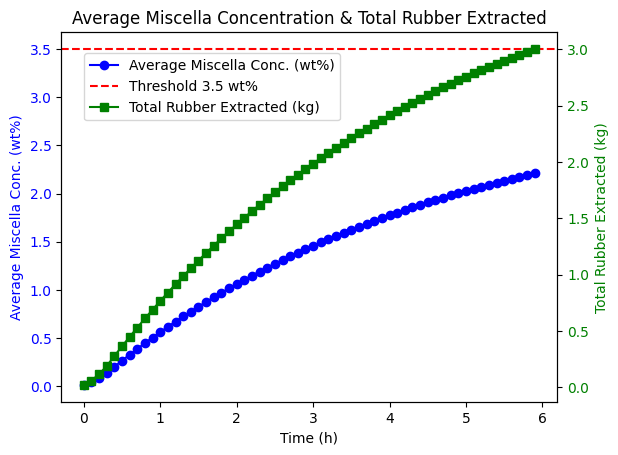

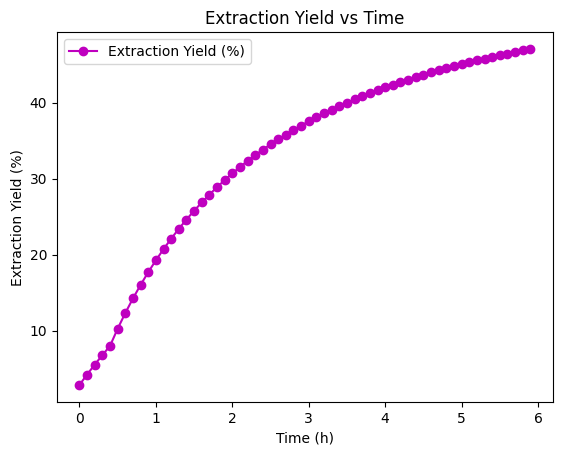

In [91]:
import numpy as np
import matplotlib.pyplot as plt

#Feed Parameters
rho_TK = 0.48 #Kg/L
tnr_content = 3 #wt%
k = 1.8e-8           # mass transfer coefficient in m/s
particle_radius = 0.00025  # 500 μm diameter, so radius = 0.25 mm = 0.00025 m

#Unit Limits and Boundary Conditions
N = 5                               # Number of Stages
total_allowed_liquid_mass = 136   # 136 kg solvent or 1 drum
feedrate = 1.75*28.31 #L/rt

#Dissolution Parameters
k = 2e-8 #rubber  mass trnasfer coefficient - dependant on particle size, agitation, temperature and solvent-soild ratio

# Variables
res_time = 6              # min per stage
max_hours = 6              # simulate up to 6 h to resemble one day
time = int(max_hours*60/res_time)

# System matrix (4 x N)
system = np.zeros((4, N))
M_S, M_L, X_S, C_L = 0, 1, 2, 3

# Initial values
system[M_L, :] = total_allowed_liquid_mass/N       # kg hexane per stage (constant)
system[M_S, 0] = feedrate*rho_TK       # solids mass (kg) in stage 1
system[X_S, 0] = tnr_content       # wt% rubber in fresh solids

# Storage
times = []
total_C_l = []
extraction_yield = []
total_rubber_extracted = []

# Simulation loop
for step in range(steps):
    t_hr = step * res_time / 60  # time in hours

    # --- Mass transfer ---
    for i in range(N):
        if system[M_S, i] > 0:  # if solids present
            # Rubber in solid (kg)
            rubber_s = system[X_S, i]/100 * system[M_S, i]

            # Rubber in liquid (kg)
            rubber_l = system[C_L, i]/100 * system[M_L, i]

            # Driving force (difference between solid and liquid conc)
            transfer_fraction = 1 - np.exp(-k * res_time * 60 / particle_radius)  # res_time in seconds
            driving_force = (system[X_S, i] - system[C_L, i]) * transfer_fraction

            # Rubber transferred (kg)
            transfered_tnr = min(rubber_s, driving_force * system[M_S, i] / 100)

            # Update solid and liquid rubber
            rubber_s -= transfered_tnr
            rubber_l += transfered_tnr

            # Update concentrations
            system[X_S, i] = 100 * rubber_s / system[M_S, i]
            system[C_L, i] = 100 * rubber_l / system[M_L, i]

    # --- Record total miscella concentration ---
    total_rubber_liquid = np.sum(system[C_L, :] * system[M_L, :] / 100)
    avg_C_l = 100 * total_rubber_liquid / total_allowed_liquid_mass
    times.append(t_hr)
    total_C_l.append(avg_C_l)
    total_rubber_extracted.append(total_rubber_liquid)

    # --- Extraction yield ---
    total_rubber_in_solids = np.sum(system[X_S, :] * system[M_S, :] / 100)
    yield_step = 100 * total_rubber_liquid / (total_rubber_liquid + total_rubber_in_solids)
    extraction_yield.append(yield_step)

    # --- Shift solids after res_time ---
    system[M_S, 1:] = system[M_S, :-1]        # move solid mass forward
    system[X_S, 1:] = system[X_S, :-1]        # move rubber wt% forward
    system[M_S, 0] = 23.0                     # fresh biomass
    system[X_S, 0] = 3.0                      # fresh rubber conc

    # stop when threshold reached
    if avg_C_l >= 3.5:
        print(f"Threshold reached at t = {t_hr:.2f} hours")
        break

# --- Plot 1: Average miscella concentration & total rubber extracted ---
fig, ax1 = plt.subplots()

ax1.plot(times, total_C_l, '-o', color='b', label='Average Miscella Conc. (wt%)')
ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Average Miscella Conc. (wt%)", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.axhline(3.5, color='r', linestyle='--', label="Threshold 3.5 wt%")

ax2 = ax1.twinx()
ax2.plot(times, total_rubber_extracted, '-s', color='g', label='Total Rubber Extracted (kg)')
ax2.set_ylabel("Total Rubber Extracted (kg)", color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.legend(loc="upper left", bbox_to_anchor=(0.15,0.85))
plt.title("Average Miscella Concentration & Total Rubber Extracted")
plt.show()

# --- Plot 2: Extraction yield ---
plt.figure()
plt.plot(times, extraction_yield, '-o', color='m', label='Extraction Yield (%)')
plt.xlabel("Time (h)")
plt.ylabel("Extraction Yield (%)")
plt.title("Extraction Yield vs Time")
plt.legend()
plt.show()